## Anomaly Detection with AutoEncoder

### Data preprocessing

dataset download: [https://www.kaggle.com/vinayak123tyagi/bearing-dataset](https://www.kaggle.com/vinayak123tyagi/bearing-dataset)

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
data_dir = "../data/nasa/2nd_test/2nd_test"

merged_data = pd.DataFrame()
# columns_names= ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
for file in os.listdir(data_dir):
    piece = pd.read_csv(os.path.join(data_dir, file), sep='\t', header=None, engine='python')
    piece_abs_mean = np.array(piece.abs().mean())
    piece_df = pd.DataFrame(piece_abs_mean.reshape(1,4))
    piece_df.index = [file]
    merged_data = merged_data.append(piece_df)
merged_data.reset_index(inplace=True)
merged_data.columns= ['Datetime','Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data.sort_values(by='Datetime', inplace=True)
merged_data.to_csv('../data/nasa/2nd_test/2nd_test_resample_10minutes.csv', index=False)
merged_data

,Datetime,Bearing 1,Bearing 2,Bearing 3,Bearing 4
311,2004.02.12.10.32.39,0.058332,0.071832,0.083244,0.043065
422,2004.02.12.10.42.39,0.058997,0.074008,0.084439,0.044540
427,2004.02.12.10.52.39,0.060239,0.074223,0.083922,0.044442
103,2004.02.12.11.02.39,0.061453,0.073843,0.084462,0.045081
62,2004.02.12.11.12.39,0.061361,0.075606,0.082837,0.045118
...,...,...,...,...,...
545,2004.02.19.05.42.39,0.453318,0.161011,0.137444,0.119042
562,2004.02.19.05.52.39,0.337575,0.132397,0.144997,0.092123
860,2004.02.19.06.02.39,0.351094,0.152259,0.151296,0.100813
906,2004.02.19.06.12.39,0.001857,0.003731,0.003656,0.001786


In [3]:
sample_data = pd.read_csv('../data/nasa/2nd_test/2nd_test_resample_10minutes.csv', 
                          index_col='Datetime', 
                          usecols=['Datetime','Bearing 1','Bearing 2','Bearing 3','Bearing 4'])
sample_data.index = pd.to_datetime(sample_data.index, format="%Y.%m.%d.%H.%M.%S")
sample_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Datetime,,,,
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.453318,0.161011,0.137444,0.119042
2004-02-19 05:52:39,0.337575,0.132397,0.144997,0.092123
2004-02-19 06:02:39,0.351094,0.152259,0.151296,0.100813


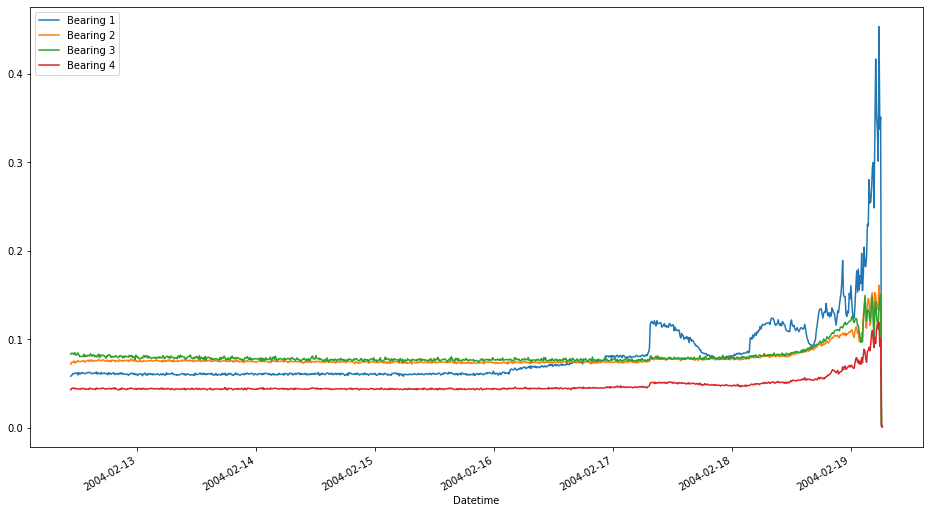

In [4]:
sample_data.plot(figsize = (16,9))

### Train/Test dataset split

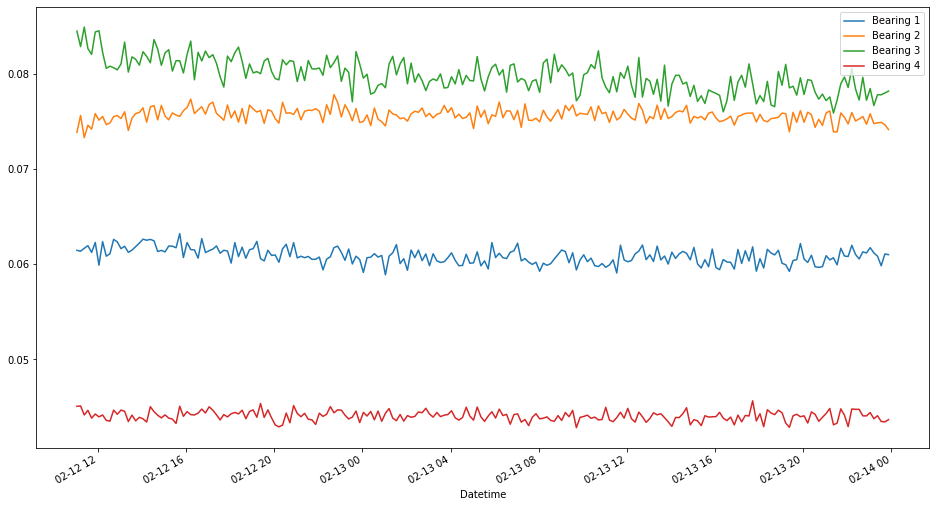

In [5]:
# short length normal data
train = sample_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test = sample_data['2004-02-13 23:52:39':]
train.plot(figsize=(16, 9))

In [31]:
# Normalize data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train),
                              columns=train.columns,
                              index=train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test),
                             columns=test.columns,
                             index=test.index)
X_train.shape

(222, 4)

### AutoEncoder Model(PyTorch)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 10),
            nn.ReLU(),
            nn.Linear(10, 2),   
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, X_train.shape[1]),
            nn.Sigmoid()       # (0, 1)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
ae = AutoEncoder()

### Train

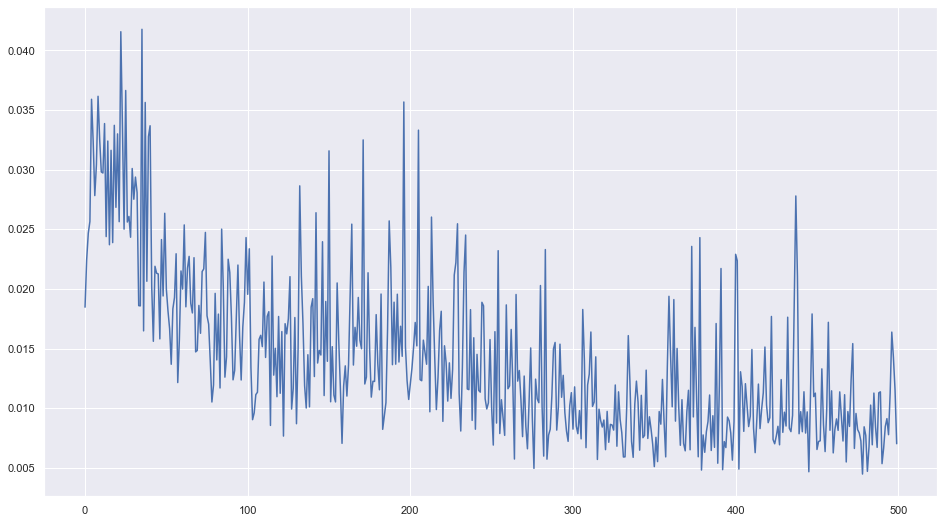

In [49]:
lr = 0.01
epoch = 500
batch_size = 10
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
loss_func = nn.MSELoss()
all_loss = []

for epoch in range(epoch):
    idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    b_x = np.array(X_train)[idx, :]
    b_x = torch.from_numpy(b_x).float()

    encoded_x, decoded_x = ae(b_x)

    loss = loss_func(decoded_x, b_x) 
    all_loss.append(loss.item())
    optimizer.zero_grad()          
    loss.backward()                
    optimizer.step() 

import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(np.array(range(epoch+1)), np.array(all_loss)) # loss 收敛较差；

### 测试模型性能
模型整体误差在[0, 0.3]区间内，超出阈值0.3则为异常；

(0.0, 0.5)

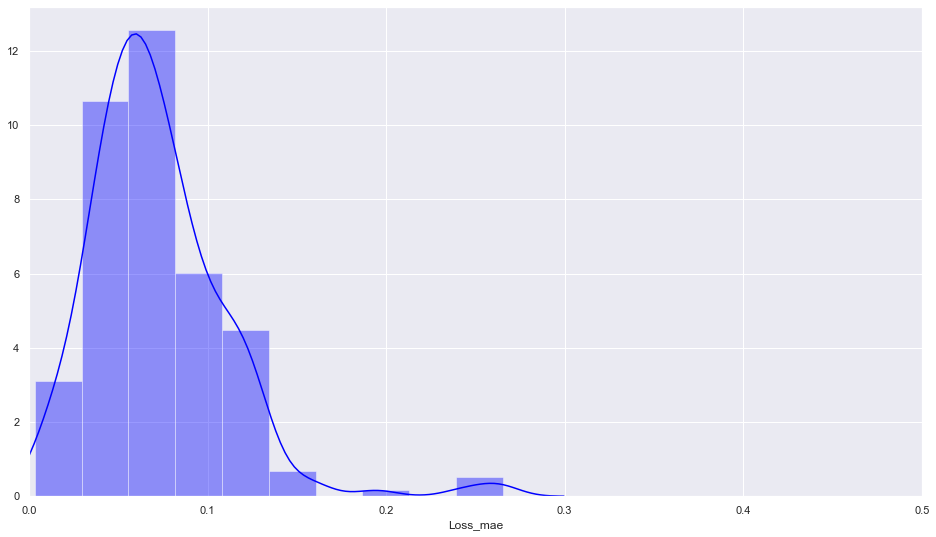

In [50]:
X_train_tensor = torch.from_numpy(np.array(X_train)).float()
X_en, X_pred = ae(X_train_tensor)

X_pred = pd.DataFrame(X_pred.detach().numpy(),
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

import seaborn as sns
plt.figure(figsize=(16, 9))
sns.set(color_codes=True)
sns.distplot(scored['Loss_mae'],
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])

,Loss_mae,Threshold,Anomaly
Datetime,,,
2004-02-13 23:52:39,0.108279,0.3,False
2004-02-14 00:02:39,0.069621,0.3,False
2004-02-14 00:12:39,0.022006,0.3,False
2004-02-14 00:22:39,0.017955,0.3,False
2004-02-14 00:32:39,0.109792,0.3,False


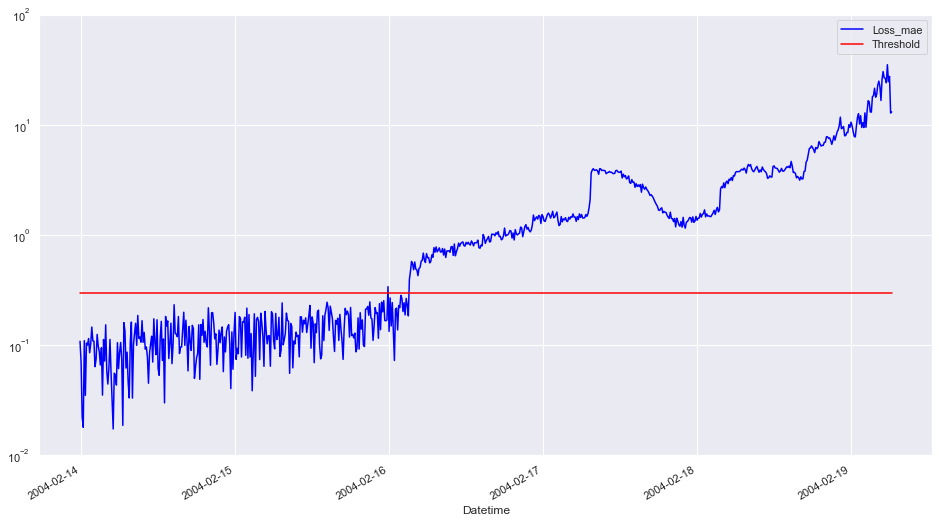

In [51]:
X_en, X_pred = ae(torch.from_numpy(np.array(X_test)).float())
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index


threshod = 0.3
scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshod
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
display(scored.head())

# X_pred_en, X_pred_train = ae(torch.from_numpy(np.array(X_train)).float())
# X_pred_train = pd.DataFrame(X_pred_train,
#                       columns=X_train.columns)
# X_pred_train.index = X_train.index

# scored_train = pd.DataFrame(index=X_train.index)
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
# scored_train['Threshold'] = threshod
# scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
# scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (16, 9), ylim = [1e-2,1e2], color = ['blue','red'])